<a href="https://colab.research.google.com/github/Zerkclown/Phonetix/blob/main/Phonetix_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## High Level Pre-Study Notes and Goals:



1. Split by space (then give a second pass to make sure it is seperate)
2. Identify (and accordingly relabel) consonants precended by a vowel in video/voice
3. multiply the dataset by speeding and slowing down each clip (0.25x, 0.5x, 0.75x, 1x, 1.25x, 1.5x, 1.75x, 2x)
4. Split voice and sound (duing processing)




To Do Notes:

how to identify normalized pace (7arakat el mad) and word stess irrespective of temporal duration/speed (husarry is correct) and inflection

will have to encode (optionally) pauses


# https://towardsdatascience.com/extracting-audio-from-video-using-python-58856a940fd

In [ ]:
! pip install pydub
! pip install moviepy
! pip install imageio==2.4.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 3.3 MB 4.9 MB/s 
  Created wheel for imageio: filename=imageio-2.4.1-py3-none-any.whl size=3303885 sha256=f0bf1bbf6c48f02fff37d643cd1970f39ee36974b2ab16cb9b7ebfbed13910c4
  Stored in directory: /root/.cache/pip/wheels/46/20/07/7bb9c8c44e6ec2efa60fd0e6280094f53f65f41767ef69a5ee
Successfully built imageio
  Attempting uninstall: imageio
    Found existing installation: imageio 2.9.0
    Uninstalling imageio-2.9.0:
      Successfully uninstalled imageio-2.9.0


#Imports and Globals

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from glob import glob

import IPython.display as ipd
from tqdm.notebook import tqdm

import subprocess
import datetime

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Helper Functions

In [ ]:
## Helper function for plotting opencv images in notebook
def display_cv2_img(img, figsize=(10, 10)):
    img_ = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img_)
    ax.axis("off")

#Reading in Data

Data is scraped from a an open sourced collection of IPA phonetical sounds pronounced while being visually captured by an MRI machine. The data is part of the Seeing Speech web resource collected collected at the University of Glasgow $^{[1]}$.

**Potential limitations** include biasing the model to the speaker's unique annunciations. Moreover, it should not scale to cases where dental or mouth medical accessories (or mouth deformaties) are introduced.

<br>

---


[1] Lawson, E., Stuart-Smith, J., Scobbie, J. M., Nakai, S. (2018). Seeing Speech: an articulatory web resource for the study of Phonetics. University of Glasgow. 28th April 2022. https://www.seeingspeech.ac.uk/

#### Reading Data Sound Types

In [ ]:
dataPaths = {
    'vowels': '/content/drive/MyDrive/IPA_Dataset/vowels',
    'pulmonicConsonants': '/content/drive/MyDrive/IPA_Dataset/consonants/pulmonic',
    'nonPulmonicConsonants': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic',
    'otherSymbols': '/content/drive/MyDrive/IPA_Dataset/other_symbols',
}

vowelSounds = [f for f in os.listdir(dataPaths['vowels']) if not os.path.isfile(os.path.join(dataPaths['vowels'], f))]
pulmonicConsonantSounds = [f for f in os.listdir(dataPaths['pulmonicConsonants']) if not os.path.isfile(os.path.join(dataPaths['pulmonicConsonants'], f))]
nonPulmonicConsonantSounds = [f for f in os.listdir(dataPaths['nonPulmonicConsonants']) if not os.path.isfile(os.path.join(dataPaths['nonPulmonicConsonants'], f))]
otherSymbolSounds = [f for f in os.listdir(dataPaths['otherSymbols']) if not os.path.isfile(os.path.join(dataPaths['otherSymbols'], f))]

In [ ]:
print(vowelSounds)
print(pulmonicConsonantSounds)
print(nonPulmonicConsonantSounds)
print(otherSymbolSounds)

['a', 'o', 'y', 'ə', 'ø', 'i', 'u', 'œ', 'ɔ', 'e', 'ɛ', 'ɨ', 'ɯ', 'ʊ', 'ʌ', 'ʉ', 'ɶ', 'ɒ', 'ɪ', 'ɑ', 'ɤ']
['b', 'c', 'd', 'f', 'h', 'm', 'p', 'q', 'l', 'k', 'j', 'r', 's', 'n', 't', 'ŋ', 'ç', 'v', 'ɖ', 'z', 'ð', 'x', 'ħ', 'ɣ', 'ɲ', 'ɦ', 'ɢ', 'ʒ', 'ʋ', 'ʈ', 'ʃ', 'ɡ', 'ʀ', 'ɟ', 'ɬ', 'ɭ', 'ɮ', 'ɰ', 'ɹ', 'ɴ', 'ɸ', 'ʁ', 'ɻ', 'ʎ', 'ɳ', 'ʂ', 'ɾ', 'ʐ', 'ʔ', 'ʕ', 'ⱱ', 'χ', 'β', 'ʝ', 'θ', 'ʟ', 'ʙ', 'ɱ', 'ɽ']
['kʼ', 'pʼ', 'sʼ', 'tʼ', 'ɓ', 'ɗ', 'ɠ', 'ǀ', 'ǂ', 'ǁ', 'ʄ', 'ǃ', 'ʛ', 'ʘ']
['ʜ', 'ɺ', 'ʑ', 'ɥ', 'ʍ', 'ɧ', 'w', 'ɕ', 'ʡ', 'ʢ']


#### Storing Data File Loaction

In [ ]:
rootPath = '/content/drive/MyDrive/IPA_Dataset/'

soundFilesWhole = []

for path, subdirs, files in os.walk(rootPath):
    for name in files:
      if not subdirs:
        soundFilesWhole.append ({'path': path, 
                            'soundLabel': path.replace(rootPath, ''),
                            'videoFile': files[0],
                            'audioFile': files[1]})

In [ ]:
print(len(soundFilesWhole)) # 104 sound types # 106 sounds # 208 sounds !Why is it increasing?

208


#Visualizing Data

#### Watching a Random Sound Clip

In [ ]:
from random import sample

randSoundSampleData = sample(soundFilesWhole, 1)[0]

print(randSoundSampleData)
ipd.Video(os.path.join(randSoundSampleData['path'], randSoundSampleData['videoFile']), embed=True, width = 400)

{'path': '/content/drive/MyDrive/IPA_Dataset/consonants/nonPulmonic/kʼ', 'soundLabel': 'consonants/nonPulmonic/kʼ', 'videoFile': 'MRI_vl_velar_ejective.mp4', 'audioFile': 'MRI_vl_velar_ejective.mp3'}


#### Reading Metadata

In [ ]:
#capture video
sampleVidCapture = cv2.VideoCapture(os.path.join(randSoundSampleData['path'], randSoundSampleData['videoFile']))
print('CAP_PROP_FRAME_COUNT: ', sampleVidCapture.get(cv2.CAP_PROP_FRAME_COUNT))
print('CAP_PROP_FPS: ', sampleVidCapture.get(cv2.CAP_PROP_FPS))
print('CAP_PROP_FRAME_HEIGHT: ', sampleVidCapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
print('CAP_PROP_FRAME_WIDTH: ', sampleVidCapture.get(cv2.CAP_PROP_FRAME_WIDTH))

CAP_PROP_FRAME_COUNT:  42.0
CAP_PROP_FPS:  7.0
CAP_PROP_FRAME_HEIGHT:  84.0
CAP_PROP_FRAME_WIDTH:  90.0


In [ ]:
# get one frame
ret, img = sampleVidCapture.read()
print(ret, img.shape)

True (84, 90, 3)


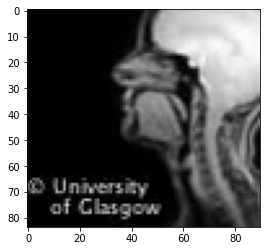

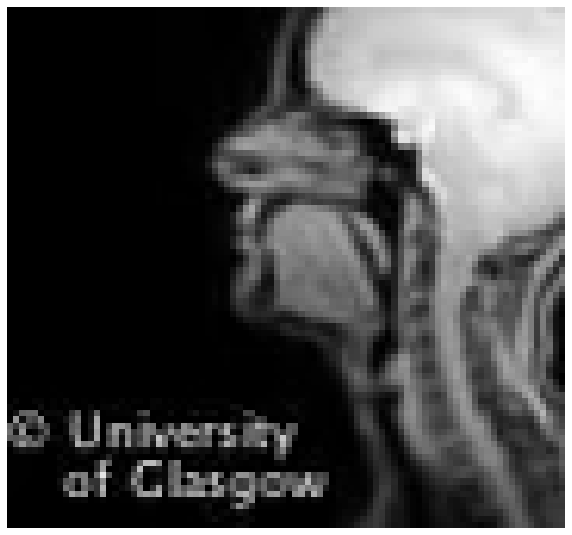

In [ ]:
# display captured frame
plt.imshow(img)
display_cv2_img(img)

In [ ]:
# release video
sampleVidCapture.release()

#### Display Video as Frames

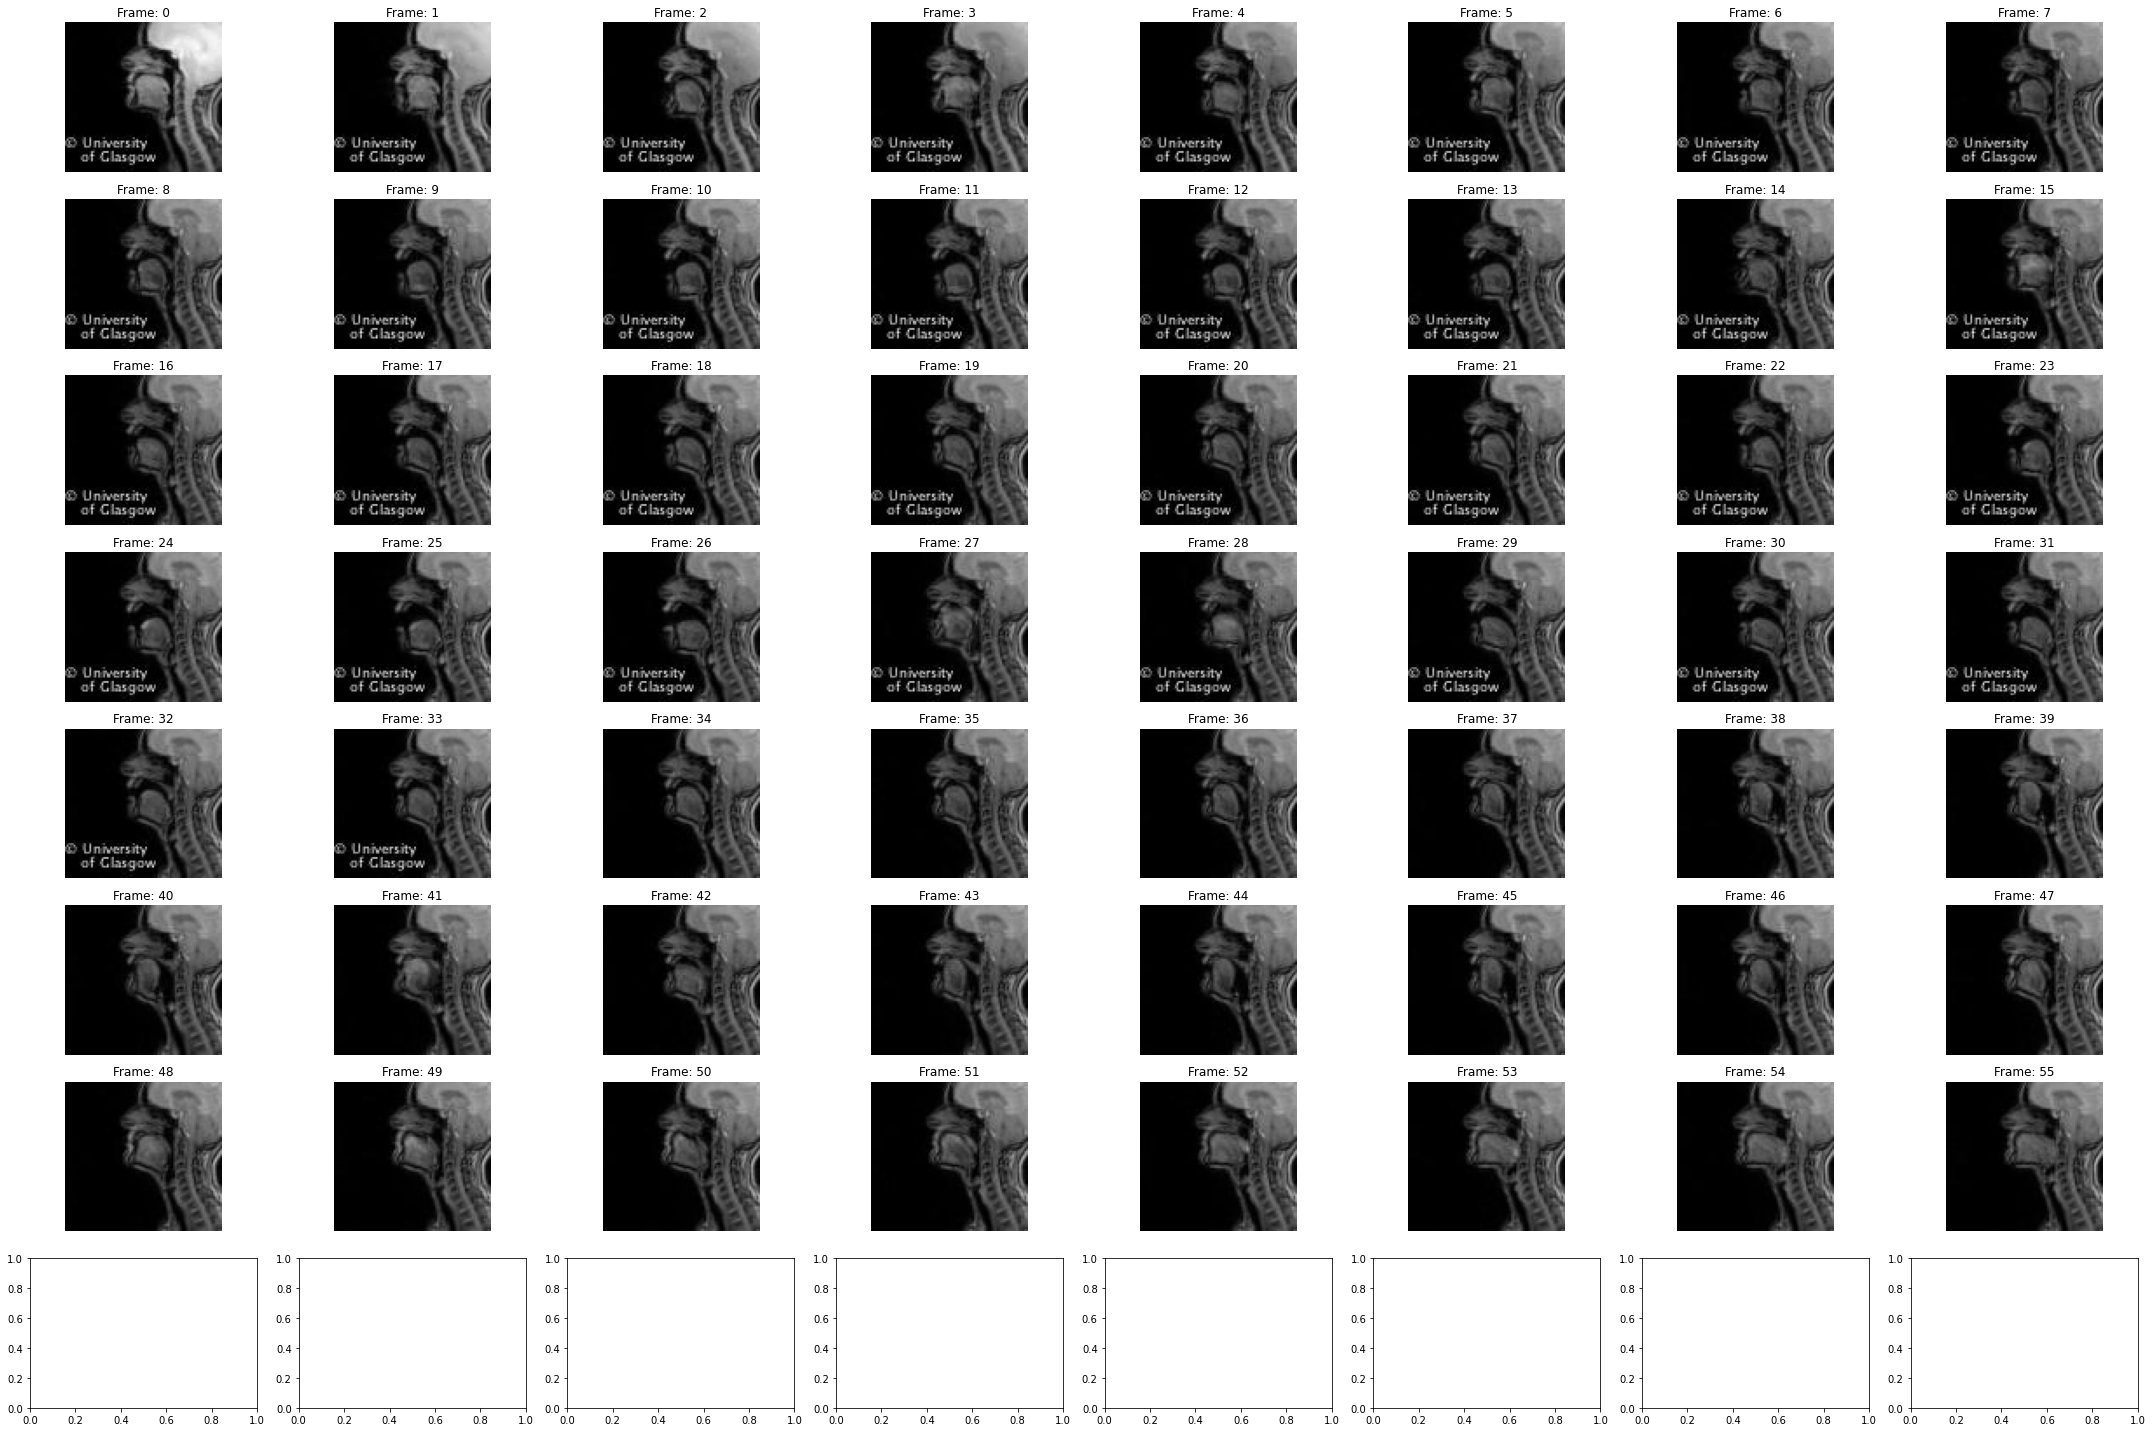

In [ ]:
from math import ceil

randSoundSampleData = sample(soundFilesWhole, 1)[0]
sampleVidCapture = cv2.VideoCapture(os.path.join(randSoundSampleData['path'], randSoundSampleData['videoFile']))
n_frames = int(sampleVidCapture.get(cv2.CAP_PROP_FRAME_COUNT))

fig, axs = plt.subplots(ceil(n_frames**0.5), ceil(n_frames**0.5), figsize=(30, 20))
axs = axs.flatten()

img_idx = 0
for frame in range(n_frames):
    ret, img = sampleVidCapture.read()
    if ret == False:
        break
    axs[img_idx].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axs[img_idx].set_title(f'Frame: {frame}')
    axs[img_idx].axis('off')
    img_idx += 1

plt.tight_layout()
plt.show()
sampleVidCapture.release()

#Augmenting Sound Clips

#### Extracting Audio from all video files

In [ ]:
import moviepy.editor as mp
import re

# TODO: split video and audio alike

# for soundFile in soundFilesWhole:
#   clip = mp.VideoFileClip(os.path.join(soundFile['path'], soundFile['videoFile']), audio=True)
#   audioFilePath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
#   audioFileName = re.sub(r'\..*', '.mp3', soundFile['videoFile'])
#   clip.audio.write_audiofile(os.path.join(audioFilePath, audioFileName))

Imageio: 'ffmpeg-linux64-v3.3.1' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg-linux64-v3.3.1 (43.8 MB)
Downloading: 8192/45929032 bytes (0.0%)2514944/45929032 bytes (5.5%)6176768/45929032 bytes (13.4%)9846784/45929032 bytes (21.4%)13565952/45929032 bytes (29.5%)17334272/45929032 bytes (37.7%)20807680/45929032 bytes (45.3%)23961600/45929032 bytes (52.2%)27828224/45929032 bytes (60.6%)31416320/45929032 bytes (68.4%)34914304/45929032 bytes (76.0%)38387712/45929032 bytes (83.6%)42180608/45929032 bytes (91.8%)

####Identifying Acustic Pauses and Spliting Recordings

In [ ]:
#https://www.youtube.com/watch?v=kuJNcWnCibY&ab_channel=OpenCV

In [ ]:

# #reading from audio mp3 file
# sound = AudioSegment.from_mp3("/content/Audio/song_with_silence.mp3")
# # spliting audio files
# audio_chunks = split_on_silence(sound, min_silence_len=500, silence_thresh=-40 )
# #loop is used to iterate over the output list
# for i, chunk in enumerate(audio_chunks):

  
#    output_file = "/content/Audio/output/chunk{0}.mp3".format(i)

#    print("Exporting file", output_file)
#    chunk.export(output_file, format="mp3")
# # chunk files saved as Output

NameError: ignored

In [ ]:
# var = 3067
# temp = datetime.datetime.fromtimestamp(var / 1000).strftime('%H:%M:%S.%f')
# print (temp)

In [ ]:
def splitVideo(inputVideoFilePath, outputVideoFilePath, startTime, endTime):

  timeFormatter = lambda time : datetime.datetime.fromtimestamp(time / 1000).strftime('%H:%M:%S.%f')

  cmd = [
      "ffmpeg", 
      "-i", inputVideoFilePath, 
      "-ss", timeFormatter(startTime),
      "-to", timeFormatter(endTime),
      "-c", "endTime",
      outputVideoFilePath
  ]

  subprocess.run(cmd, shell=True, env=os.environ.copy())
  # subprocess.run(cmd)

  # TODO: fix subprocess!!!! it is not working for me

In [ ]:
from pydub import AudioSegment
from pydub.silence import split_on_silence, detect_nonsilent

for soundFile in soundFilesWhole[:1]:
  inputAudioFilePath = os.path.join(soundFile['path'], soundFile['audioFile'])
  # reading from audio mp3 file
  sound = AudioSegment.from_mp3(inputAudioFilePath) 
  # spliting audio files
  audioChunks = split_on_silence(sound, min_silence_len=500, silence_thresh=-40)
  timeStamps = detect_nonsilent(sound, min_silence_len=500, silence_thresh=-40)

  print(timeStamps)
  outputAudioFilePath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
  #loop is used to iterate over the output list
  for i, chunk in enumerate(audioChunks):
    audioChunkName = re.sub(r'(\..*)', f'{i}' + r'\1', soundFile['audioFile'])
    outputFilePath = os.path.join(outputAudioFilePath, audioChunkName)
    print("Exporting file", outputFilePath)
    chunk.export(outputFilePath, format="mp3")

    inputVideoFilePath = os.path.join(soundFile['path'], soundFile['videoFile'])
  for i, (startTime, endTime) in enumerate(timeStamps):
    videoFilePath = re.sub(r'(^.*\/)(IPA_Dataset)', r'\1Destination_\2', soundFile['path'])
    videoFileName = re.sub(r'(\..*)', f'{i}' + r'\1', soundFile['videoFile'])
    outputVideoFilePath = os.path.join(videoFilePath, videoFileName)

    print(f'outputVideoFilePath: {outputVideoFilePath}')

    # spliting video into chunks
    splitVideo(inputVideoFilePath, outputVideoFilePath, startTime, endTime)

[[675, 884], [1884, 3067]]
Exporting file /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative0.mp3
Exporting file /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative1.mp3
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative0.mp4
outputVideoFilePath: /content/drive/MyDrive/Destination_IPA_Dataset/other_symbols/ʜ/MRI_vl_epiglottal_fricative1.mp4


In [ ]:
#https://stackoverflow.com/questions/68800899/is-there-are-way-to-split-videos-into-smaller-chunks-of-videos-in-python

####Cropping Exess Pixels (Including Watermark)

In [ ]:
#https://stackoverflow.com/questions/57354527/cropping-video-with-opencv-in-python-mac

#Creating Animation Skeleton (Finding Rigging Points) [must find reference]